# Generate figures used in the paper

Generate some figures used in the paper that are not generated elsewhere.

In [2]:
import os

import json
import geopandas
import pandas
import numpy
import shapely
from shapely.geometry import Point, Polygon
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import rcParams
import seaborn as sns
from palettable.cartocolors.qualitative import Bold_6
import contextily as cx

Set default plotting themes/parameters and add color dictionary for continents.

In [3]:
# figure settings and init
rcParams.update({"figure.autolayout": True})
mypalette = Bold_6.hex_colors
mybarwidth = 0.5

sns.set_theme(
    context="paper",
    style="ticks",
    rc={
        "patch.force_edgecolor": False,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": True,
    },
    palette=mypalette,
)

coldict = {
    "Africa": 0,
    "Asia": 1,
    "Europe": 2,
    "North America": 3,
    "Oceania": 4,
    "South America": 5,
}

Subfolders for plots

In [4]:
mydirs = ["../plots/paper/"]

for mydir in mydirs:
    os.makedirs(mydir, exist_ok=True)

Load metadata

In [5]:
sample = geopandas.read_parquet("../data/sample.parquet")
sample["eFUA_ID"] = sample.apply(lambda x: int(x.eFUA_ID), axis=1)

# load peak results
results = json.load(open("../results/04_peaks_results.json"))

# load parameters (metric names)
options = [
    "circular_compactness_index",
    "isoperimetric_quotient_index",
    "isoareal_quotient_index",
    "radii_ratio_index",
    "diameter_ratio_index",
]

option_labels = [opt.replace("_", " ").replace("index", "") for opt in options]

In [6]:
# load comp perform results
perf = pandas.read_csv("../results/performance.csv", index_col=0)
perf.columns = [c.replace("_", " ") for c in perf.columns]

In [7]:
cities_for_validation = [
    "Abidjan",
    "Conakry",
    "Douala",
    "Mogadishu",  # Africa
    "Aleppo",
    "Kabul",
    "Semarang",
    "Seoul",  # Asia
    "Bucaramanga",
    "Porto Alegre",  # South America
    "Cincinnati",
    "Dallas",
    "Ottawa",
    "Raleigh",
    "Richmond",
    "Río Piedras [San Juan]",
    "Salt Lake City",
    "San Jose",
    "Washington D.C.",  # North America
    "Auckland",  # Oceania
    "Amsterdam",
    "Belgrade",
    "Chelyabinsk",
    "Cologne",
    "Dortmund",
    "Helsinki",
    "Katowice",
    "Krakow",
    "Liège",
    "London",
    "Nuremberg",
    "Saratov",
    "Vienna",
    "Warsaw",  # Europe
]

sample_validation = sample[sample.eFUA_name.isin(cities_for_validation)]

***
***
**Figure 1** 

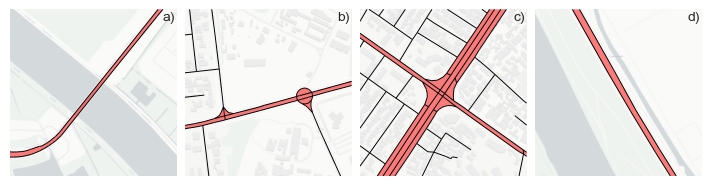

In [7]:
# Figure 1: Zoom-in plots of face artifacts in 4 different cities

points = {}

for city in ["Amsterdam", "Abidjan", "Kabul", "Vienna"]:
    points[city] = {}

points["Amsterdam"]["coord"] = (5.0092,52.3368)
points["Amsterdam"]["text"] = "Bridge"

points["Abidjan"]["coord"] = (-3.98987,5.35023)
points["Abidjan"]["text"] = "Roundabout" 

points["Kabul"]["coord"] = (69.1485, 34.543)
points["Kabul"]["text"] = "Intersection"

points["Vienna"]["coord"] = (16.3586,48.2886)
points["Vienna"]["text"] = "Motorway"

fig, ax = plt.subplots(1,4,figsize = (7,2), layout = "constrained")

axs = [ax[0], ax[1], ax[2], ax[3]]

for i, city in enumerate(points.keys()):

    city_id = int(sample.loc[sample["eFUA_name"]==city, "eFUA_ID"].values)
    fua = geopandas.read_parquet(f"../data/{int(city_id)}/polygons/")

    # define a subplot for this city:
    center = geopandas.GeoDataFrame(geometry = [Point(points[city]["coord"])], crs = "epsg:4326")
    center = center.to_crs(fua.crs)
    center = center.buffer(250,cap_style=3)

    # clip geometries to box
    fua = fua.clip(center)

    # get street edge data, also clipped
    edges = geopandas.read_parquet(f"../data/{city_id}/roads_osm.parquet").clip(center)
    edges = edges[edges.highway != "service"]
    
    # add face artifacts
    fua[fua.is_artifact == True].plot(
        ax=axs[i], color="red",
        alpha=0.5
        )
    
    # add true urban blocks
    fua[fua.is_artifact == False].plot(
        ax=axs[i], color=mypalette[3],
        alpha=0
        )
    
    # add street edges
    edges.plot(ax=axs[i], color="black", lw=.7)

    # no axis
    axs[i].set_axis_off()
    artifact_type = points[city]["text"]
    # axs[i].set_title(f"{artifact_type}, {city}", fontsize = 24)

    # add basemap
    cx.add_basemap(ax=axs[i], source = cx.providers.CartoDB.Positron, crs = edges.crs, attribution="")
    bds = center.total_bounds
    axs[i].set_xlim(bds[0], bds[2])
    axs[i].set_ylim(bds[1], bds[3])
        
# add subplot labels
for i, lab in enumerate(["a)", "b)", "c)", "d)"]):
    axs[i].text(
        .99, .99, 
        lab, 
        horizontalalignment='right', 
        verticalalignment='top', 
        transform=axs[i].transAxes, 
        fontsize = 10
        )

plt.show()

fig.savefig("../plots/paper/face_artifacts.png", dpi = 300, bbox_inches = "tight")

***
**Figure 2**

Spatial distribution of FUAs >> see notebook `10_fua_map`

***
**Figure 3**

Pairwise scatter plots and histograms of five shape metrics for a combined sample of all 131 FUAs >> see notebook `03_shapestats_comparison`

***
**Figure 4**

Face artifact index distributions for different cities and compactness metrics

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


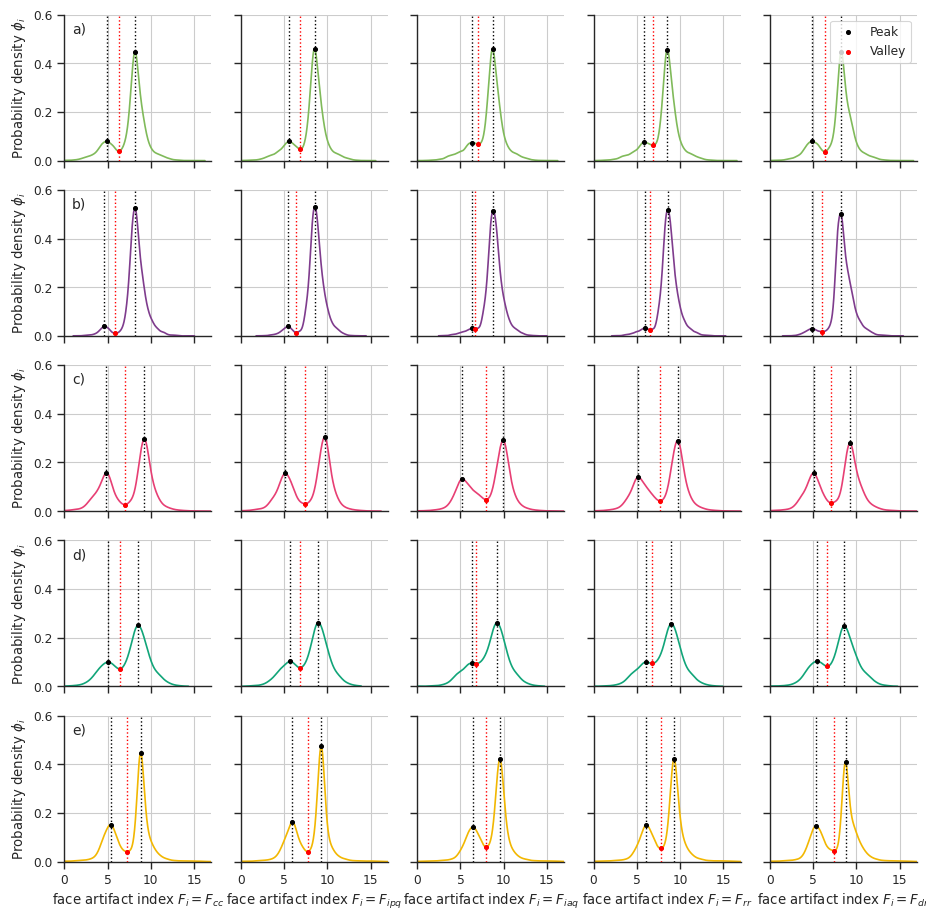

/tmp/ipykernel_102/2113883752.py:101: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.savefig(f"../plots/paper/phis.png", dpi=300)


In [7]:
# Figure with phi_i distributions for 5 example cities

fai = [r"$F_{i}=F_{cc}$", r"$F_{i}=F_{ipq}$", r"$F_{i}=F_{iaq}$", r"$F_{i}=F_{rr}$", r"$F_{i}=F_{dr}$"]

# initiate plot
fig, ax = plt.subplots(
    5, 5, figsize=(11, 11), 
    sharex=True, 
    sharey=True, 
    #layout="constrained"
)

for i, city in enumerate(["Cochabamba", "Douala", "Sydney", "Tbilisi", "Montreal"]):

    # get continent color
    continent = sample[sample.eFUA_name == city]["continent"].values[0]
    continent_color = sns.color_palette(n_colors=6)[coldict[continent]]

    for j, option in enumerate(options):

        my_pdf = numpy.array(results[city][option]["pdf"])

        mylinspace = numpy.linspace(
            start=results[city][option]["linspace_params"]["start"],
            stop=results[city][option]["linspace_params"]["stop"],
            num=results[city][option]["linspace_params"]["num"],
        )

        # plot vlines at identified peak (local max) points
        ax[i,j].vlines(
            x=mylinspace[results[city][option]["peaks"]],
            ymin=0,
            ymax=1,
            colors="black",
            linestyles="dotted",
            alpha=1,
            linewidth=1,
            zorder = 2
        )

        # plot vlines at identified valley (local min) points
        ax[i,j].vlines(
            x=mylinspace[results[city][option]["valleys"]],
            ymin=0,
            ymax=1,
            colors="red",
            linestyles="dotted",
            alpha=1,
            linewidth=1,
            zorder = 3
        )

        # plot pdf
        ax[i,j].plot(mylinspace, my_pdf, color=continent_color, zorder=1)

        # add scatter points at pdf/vline intersections
        if len(my_pdf[results[city][option]["peaks"]])>0:
            ax[i,j].scatter(
                x=mylinspace[results[city][option]["peaks"]],
                y=my_pdf[results[city][option]["peaks"]],
                color="black",
                s=8,
                alpha=1,
                zorder=4,
                label = "Peak"
            )

        if len(my_pdf[results[city][option]["valleys"]])>0:
            ax[i,j].scatter(
                x=mylinspace[results[city][option]["valleys"]],
                y=my_pdf[results[city][option]["valleys"]],
                color="red",
                s=8,
                alpha=1,
                zorder=5,
                label = "Valley"
            )
        if i == 4:
            ax[i,j].set_xlabel(f"face artifact index {fai[j]}")
        if j == 0:
            ax[i,j].set_ylabel(r"Probability density $\phi_{i}$")
        # if j == 2:
        #     ax[i,j].set_title(city, fontsize = 24)
        ax[i,j].set_xlim([0, 17])
        ax[i,j].set_ylim([0, 0.6])
        if j == 4 and i == 0:
            ax[i,j].legend()

# add subplot labels
for i, lab in enumerate(["a)", "b)", "c)", "d)", "e)"]):
    ax[i,j].text(
        .05, .95, 
        lab, 
        horizontalalignment='left', 
        verticalalignment='top', 
        transform=ax[i,0].transAxes, 
        fontsize = 10
        )

plt.show()
fig.savefig(f"../plots/paper/phis.png", dpi=300)

***
**Figure 5**

Example birdview plots

In [43]:
sample.query("eFUA_name == 'Tijuana'")

,eFUA_ID,UC_num,UC_IDs,eFUA_name,Commuting,Cntry_ISO,Cntry_name,FUA_area,UC_area,FUA_p_2015,UC_p_2015,Com_p_2015,geometry,continent,iso_a3
592,2204,1.0,21,Tijuana,1.0,USA,UnitedStates,3940.0,1480.0,3.177732e+06,2.831244e+06,346488.649099,"POLYGON ((-117.24452 33.38128, -117.23336 33.3...",North America,USA


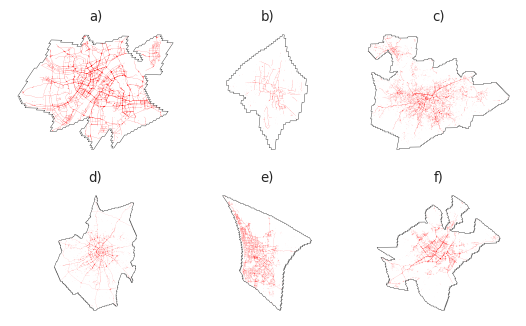

In [44]:
option = "circular_compactness_index"

# initialize figure
fig, ax = plt.subplots(2,3,figsize = (7,4), layout = "constrained")
axs = ax.flatten()

cities = [
    "Wuhan", # asia
    "Khartoum", # africa
    "São Paulo", # south am
    "Moscow", # europe
    "Perth", # oceania
    "Montreal", # north am
]

for i, city in enumerate(cities):

    threshold = results[city][option]["threshold"]

    # get block data for current city
    city_id = int(sample.loc[sample["eFUA_name"]==city, "eFUA_ID"].values)
    fua = geopandas.read_parquet(f"../data/{int(city_id)}/polygons/")
        
        
    # plot FUA boundary
    sample[sample["eFUA_name"]==city].to_crs(fua.crs).exterior.plot(
        ax=axs[i], linewidth = 0.25, color = "black", 
        #linestyle = "dotted"
        )

    # plot street artifacts
    fua[fua["circular_compactness_index"] <= threshold].buffer(20).plot(
        ax=axs[i], color="red", alpha=1
    )

    axs[i].set_axis_off()
#    axs[i].set_title(city)

# add subplot labels
for i, lab in enumerate(["a)", "b)", "c)", "d)", "e)", "f)"]):
    axs[i].set_title(f"{lab}")
    # axs[i].text(
    #     0, 0, 
    #     lab, 
    #     horizontalalignment='left', 
    #     verticalalignment='bottom', 
    #     transform=axs[i].transAxes, 
#        fontsize = 10
    #    )


fig.savefig(f"../plots/paper/birdviews.png", dpi=300, bbox_inches="tight")
plt.show()

***
**Figure 6**

Validating the heuristic with OSM building data

100%|██████████| 34/34 [00:04<00:00,  7.58it/s]


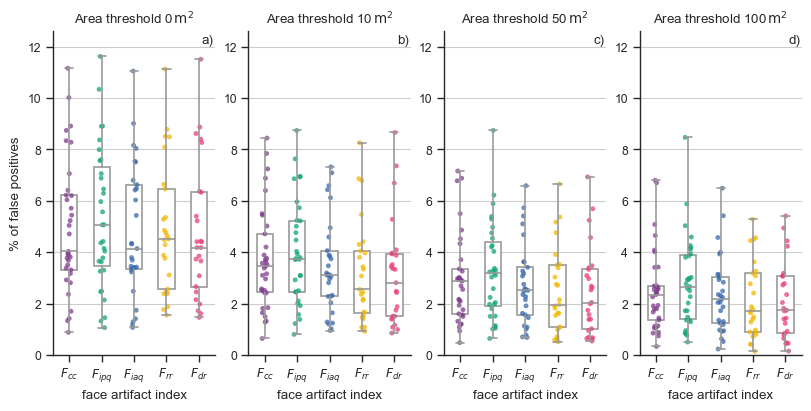

In [16]:
fai = [r"$F_{cc}$", r"$F_{ipq}$", r"$F_{iaq}$", r"$F_{rr}$", r"$F_{dr}$"]
xs = numpy.arange(0,5)

fig, subax = plt.subplots(1, 4, layout="constrained", figsize=(8,4))

for i, area_threshold in enumerate([0,10,50,100]):
    df_cities, df_options, df_fps = [], [], []
    for ix, row in tqdm(sample_validation.iterrows(), total=len(sample_validation)):
        city = row.eFUA_name
        myid = row.eFUA_ID
        polygons = geopandas.read_parquet(f"../data/{int(myid)}/polygons/")
        for option in options:
            threshold = results[city][option]["threshold"]
            nr_tot = len(polygons)
            nr_art = len(polygons[polygons[option]<threshold])
            if nr_art > 0:
                nr_fp = len(polygons[(polygons[option]<threshold) & (polygons["intersection_area"]>area_threshold)])
                pct_fp = numpy.round(100*nr_fp/nr_art, 2)
            else: 
                pct_fp = "nan"
            df_cities.append(city)
            df_options.append(option)
            df_fps.append(pct_fp)
        df = pandas.DataFrame()
        df["city"] = df_cities
        df["option"] = df_options
        df["pct_fp"] = df_fps
        df.drop(numpy.where(df.pct_fp == "nan")[0], axis = 0, inplace = True)
        df.drop(df[df["city"]=="Mogadishu"].index, axis = 0, inplace = True)
    sns.boxplot(
        ax=subax[i], 
        data = df,
        x = "option", 
        y = "pct_fp",
        whis=[0, 100], 
        width=.5,
        color="white",
        saturation = 0.2,
    )
    sns.stripplot(
        ax=subax[i],
        data = df, 
        x = "option",
        y = "pct_fp", 
        hue = "option",
        dodge = False, 
        alpha = 0.75, 
        zorder = 1, 
        legend=False,
        palette=mypalette[0:5],
        size = 3.5
        );

    subax[i].set_xticks(xs, fai, rotation=0)
    subax[i].set_ylim(ymin = 0, ymax = 12.6)
    subax[i].set_xlabel("face artifact index")
    subax[i].set_title(f"Area threshold {area_threshold}" + r'$\/\mathrm{m^{2}}$')
    subax[i].set_ylabel("") # override seaborn's automatic labelling

# add subplot labels
for i, lab in enumerate(["a)", "b)", "c)", "d)"]):
    subax[i].text(
        .99, .99, 
        lab, 
        horizontalalignment='right', 
        verticalalignment='top', 
        transform=subax[i].transAxes, 
  #      fontsize = 10
        )


subax[0].set_ylabel("% of false positives")
plt.show()
fig.savefig("../plots/paper/valid.png", dpi = 300, bbox_inches = "tight")

***
**Figure 7**

scatter plot of individual polygons based on their area and circular compactness >> see notebook `11_banana_plot`

***
**Figure 8**

Evaluating compactness metrics

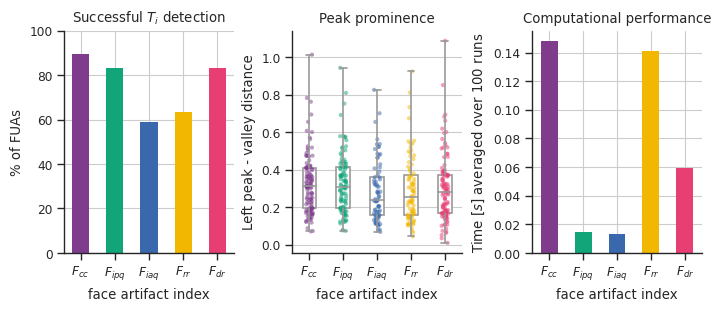

In [24]:
fai = [r"$F_{cc}$", r"$F_{ipq}$", r"$F_{iaq}$", r"$F_{rr}$", r"$F_{dr}$"]
xs = numpy.arange(0,5)

fig, axs = plt.subplots(
    1, 3, 
    layout = "constrained", 
    figsize=(7,3))

# set up grid
ax1 = axs[0]
ax2 = axs[1]
ax3 = axs[2]

# Subplot1: Comparison of metrics: what percentage of thresholds could be found?
thresholds_found = [
    sum([results[city][option]["threshold"] != False for city in results.keys()])
    for option in options
]
thresholds_found_pct = [100 * t / len(results.keys()) for t in thresholds_found]

ax1.bar(
    x=xs, 
    height=thresholds_found_pct, 
    width=mybarwidth,
    color = mypalette[0:5])
ax1.set_ylim((0, 100))
ax1.set_xticks(xs, fai)
ax1.set_xlabel("face artifact index")
ax1.set_ylabel("% of FUAs")
ax1.set_title(r"Successful $T_{i}$ detection")


# Subplot2: How pronounced is the valley/peak?
ax2.set_title("Peak prominence")

# prepare data
df = pandas.DataFrame()
df["Continent"] = [sample.loc[sample["eFUA_name"]==city, "continent"].values[0] for city in results.keys()]
for option in options:
    y_diff_left = []
    for city in results.keys():
        if results[city][option]["threshold"] != False:
            y_diff_left.append(
                results[city][option]["y_diff_max"]
                )
        else:
            y_diff_left.append("nan")
    df["ydiffleft_"+option] = y_diff_left
df = pandas.melt(df, "Continent")
df.drop(numpy.where(df.value == "nan")[0], axis = 0, inplace = True)

# plot
sns.boxplot(
    ax=ax2, 
    data = df,
    x = "variable", 
    y = "value",
    whis=[0, 100], 
    width=.4,
    color="white",
    saturation = 0.2,
)
sns.stripplot(
    ax=ax2,
    data = df, 
    x = "variable",
    y = "value", 
    hue = "variable",
    dodge = False, 
    alpha = 0.5, 
    zorder = 1, 
    legend = False,
    palette = mypalette[0:5],
    size = 3,
    );
ax2.set_ylabel("Left peak - valley distance");
ax2.set_xticks(xs, fai)
ax2.set_xlabel("face artifact index")

# Subplot3: computational performance
ax3.set_title("Computational performance")
means = perf.mean()
means.plot.bar(
    ax=ax3,
    color=mypalette[0:5]
    )
ax3.set_ylabel(r"Time $[s]$ averaged over 100 runs")
ax3.set_xticks(xs, fai, rotation = 0)
ax3.set_xlabel("face artifact index")
plt.show()
fig.savefig("../plots/paper/eval.png", dpi = 300, bbox_inches = "tight")

***
**Figure 9**

Conceptual illustration of the composition of phi >> see notebook `12_distributions_overlap_plot`

***
**Figure 10**

Geographical differences plot >> see notebook `13_geog_differences`